## setup

In [1]:
import sys
print(sys.version_info)
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print ("Scikit-Learn version: ", sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Where to save the figures
from pathlib import Path

# 각자 알맞은 path를 지정(필수는 아님)
IMAGES_PATH = Path() / "training" / "NN"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
Scikit-Learn version:  1.3.0


In [2]:
import matplotlib.pyplot as plt

def plot_digit(image_data, axis=False):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")

    if not axis:
        plt.axis("off")

def plot_multi(img,start=0,end=100):
    plt.figure(figsize=(9, 9))
    for idx, image_data in enumerate(img[start:end]):
        plt.subplot(10, 10, idx + 1)
        plot_digit(image_data)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

def plot_multi_random(images,labels):

    # 무작위로 100개의 인덱스 선택
    random_indices = np.random.choice(len(images), size=100, replace=False)

    # 선택된 인덱스에 해당하는 이미지와 레이블 시각화
    fig, axes = plt.subplots(10, 10, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        index = random_indices[i]
        image = images[index].reshape(28, 28)
        label = labels[index]
        ax.imshow(image, cmap='binary')
        ax.set_title(f"Label: {label}")
        ax.axis('on')
    plt.tight_layout()
    plt.show()

import random

# 데이터셋 순서 섞기
def shuffle_dataset(X, y):
    shuffle_idx = np.random.permutation(len(X))
    X_shuffled = X[shuffle_idx]
    y_shuffled = y[shuffle_idx]
    return X_shuffled, y_shuffled

def is_numpy(arr):
    return isinstance(arr, np.ndarray)


## data preparation

In [3]:
from pathlib import Path

# this is where the datasets are located
path = Path() / "dataset_cleaned"
print(path)

dataset_cleaned


In [8]:
from sklearn.datasets import fetch_openml

openml = fetch_openml('mnist_784', as_frame=False, parser="auto")
mnist = openml

# 레이블 수정 된 handmade MNIST
num_trVal_relabeled = np.load(path / "digit_data_TrVal_relabeled_v2.npz")
num_test_relabeled = np.load(path / "digit_data_10_Test_relabeled_v2.npz")
sym_trVal_relabeled = np.load(path / "op_data_TrVal_relabeled_v2.npz")
sym_test_relabeled = np.load(path / "op_data_10_Test_relabeled_v2.npz")

# 합체?
X_train_relabeled = np.concatenate((num_trVal_relabeled['img'], sym_trVal_relabeled['img']), axis=0)
X_test_relabeled = np.concatenate((num_test_relabeled['img'], sym_test_relabeled['img']), axis=0)
y_train_relabeled = np.concatenate((num_trVal_relabeled['label'], sym_trVal_relabeled['label']), axis=0)
y_test_relabeled = np.concatenate((num_test_relabeled['label'], sym_test_relabeled['label']), axis=0)

# 모양 일치
X_train_relabeled = X_train_relabeled.reshape(len(X_train_relabeled),784)
X_test_relabeled = X_test_relabeled.reshape(len(X_test_relabeled),784)

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

#original MNIST
mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X, y = mnist.data, mnist.target

In [ ]:
from scipy.ndimage import shift, rotate
from sklearn.preprocessing import Binarizer
import cv2


def rotate_image(images, x, threshold=0.5):
    images = images.reshape(len(images),28,28)
    augmented_images = []
    for img in images:
        rotated_image = rotate(img, x, reshape=False)
        augmented_images.append(rotated_image.reshape(784))

    binarizer = Binarizer(threshold=threshold)
    binarized_images = binarizer.fit_transform(augmented_images)

    return np.array(binarized_images)


def augment_data(images, scale=1.05, threshold=0.5):
    images = images.reshape(len(images),28,28)
    augmented_images = []
    for img in images:
        width = int(img.shape[1] * scale)
        height = int(img.shape[0] * scale)
        dim = (width, height)
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        if scale > 1:  # 확대인 경우 중앙을 crop
            start = int((scale - 1) * img.shape[0] / 2)
            end = start + img.shape[0]
            resized = resized[start:end, start:end]
        else:  # 축소인 경우 padding을 추가
            pad = int((img.shape[0] - resized.shape[0]) / 2)
            resized = cv2.copyMakeBorder(resized, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=0)
        # 이미지를 784로 reshape
        reshaped = resized.reshape(784)
        augmented_images.append(reshaped)

    binarizer = Binarizer(threshold=threshold)
    binarized_images = binarizer.fit_transform(augmented_images)

    return np.array(binarized_images)

In [ ]:
X_train_relabeled_right_15 = rotate_image(X_train_relabeled, -15)

In [ ]:
X_train_relabeled_augmented = np.concatenate((X_train_relabeled, X_train_relabeled_right_15), axis=0)
y_train_relabeled_augmented = np.concatenate((y_train_relabeled, y_train_relabeled), axis=0)

X_train_relabeled_augmented, y_train_relabeled_augmented = shuffle_dataset(X_train_relabeled_augmented, y_train_relabeled_augmented)

In [ ]:
# 데이터셋 결합
X_combined = np.concatenate((X, X_train_relabeled), axis=0)
y_combined = np.concatenate((y, y_train_relabeled), axis=0)

X_combined_augmented = np.concatenate((X, X_train_relabeled_augmented), axis=0)
y_combined_augmented = np.concatenate((y, y_train_relabeled_augmented), axis=0)

X_combined, y_combined = shuffle_dataset(X_combined, y_combined)
X_combined_augmented, y_combined_augmented = shuffle_dataset(X_combined_augmented, y_combined_augmented)

In [ ]:
len(X_combined_augmented)

In [ ]:
from sklearn.model_selection import train_test_split


# 데이터를 train, valid, test로 나눕니다
X_train_combined, X_temp, y_train_combined, y_temp = train_test_split(X_combined, y_combined, test_size=0.4, random_state=42)
X_valid_combined, X_test_combined, y_valid_combined, y_test_combined = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 각 데이터셋의 크기를 확인합니다
print(f"증강안된 데이터 전체 개수: {len(X_combined)}")  # 70000 + 30000

print(f"증강안된 Train 데이터 개수: {len(X_train_combined)}")
print(f"증강안된 Valid 데이터 개수: {len(X_valid_combined)}")
print(f"증강안된 Test 데이터  개수: {len(X_test_combined)}")


# 데이터를 train, valid, test로 나눕니다
X_train_combined_augmented, X_temp, y_train_combined_augmented, y_temp = train_test_split(X_combined_augmented, y_combined_augmented, test_size=0.2, random_state=42)
X_valid_combined_augmented, X_test_combined_augmented, y_valid_combined_augmented, y_test_combined_augmented = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 각 데이터셋의 크기를 확인합니다
print(f"증강된 데이터 전체 개수: {len(X_combined_augmented)}") # 70000 + 3000 + 120000

print(f"증강된 Train 데이터 개수: {len(X_train_combined_augmented)}")
print(f"증강된 Valid 데이터 개수: {len(X_valid_combined_augmented)}")
print(f"증강된 Test 데이터  개수: {len(X_test_combined_augmented)}")

## preprocessing function

In [6]:
def rebase_center(img):
    r = 28
    c = 28

    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1

    for n in range(r):
        for m in range(c):

            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)

    # print(r_top,r_bot,c_left,c_right)

    c_len = c_right - c_left + 1
    r_len = r_bot - r_top + 1

    c_start = int((c - c_len) / 2)
    r_start = int((r - r_len) / 2)

    # print(c_len,r_len,c_start,r_start)

    rebased_data = np.zeros((r, c), dtype="float64")

    # rebase into a center
    rebased_data[r_start:r_start + r_len, c_start:c_start + c_len] = img[r_top:r_bot + 1, c_left:c_right + 1]

    return rebased_data


def detect_del_boundary(img, thickness=3, threshold=15):
    curr = np.reshape(img, (28, 28))

    # how much you want to look at
    t = thickness
    # the threshold
    threshold_t = threshold

    for i in range(thickness):
        cnt_top = np.count_nonzero(curr[i:i + 1, :])
        cnt_down = np.count_nonzero(curr[28 - i:28 - i + 1, :])
        cnt_left = np.count_nonzero(curr[:, i:i + 1])
        cnt_right = np.count_nonzero(curr[:, 27 - i:27 - i + 1])

        if cnt_top > threshold_t:
            curr[0:t, :] = 0.

        if cnt_down > threshold_t:
            curr[28 - t:28, :] = 0.

        if cnt_left > threshold_t:
            curr[:, 0:t] = 0.

        if cnt_right > threshold_t:
            curr[:, 28 - t:28] = 0.

    return curr

def dfs(r, c, img, visited):
    st = list()
    st.append([r, c])

    cord = [[1, 1], [1, 0], [1, -1], [0, 1], [0, -1], [-1, 1], [-1, 0], [-1, -1]]

    dot = list()

    while st:
        curr = st.pop()

        if visited[curr[0]][curr[1]] == 1.: continue

        dot.append(curr)
        visited[curr[0]][curr[1]] = 1.

        for n, m in enumerate(cord):
            row = curr[0] + m[0]
            col = curr[1] + m[1]

            if 0 <= row < 28 and 0 <= col < 28:
                if img[row][col] != 0. and visited[row][col] == 0.:
                    st.append([row, col])

    return dot, visited


def d_deletion(img, dot_size=4):
    # to check whether we visited
    isVisited = np.full((28, 28), 0.)

    # dots that needs to be deleted afterwards
    dots = list()

    for i in range(28):
        for j in range(28):
            if img[i][j] != 0. and not isVisited[i][j]:
                dot, isVisited = dfs(i, j, img, isVisited)

                if len(dot) <= dot_size:
                    dots.extend(dot)

        for n, m in enumerate(dots):
            img[m[0], m[1]] = 0.

    return img


def resize(img, size=20):
    r = 28
    c = 28

    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1

    for n in range(r):
        for m in range(c):

            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)

    row_len = r_bot - r_top + 1
    col_len = c_right - c_left + 1

    adjusted_img = img[r_top:r_bot + 1, c_left:c_right + 1]

    diff = abs(row_len - col_len)

    top_pad = int(diff / 2)
    down_pad = int(diff / 2)

    if diff % 2 == 1:
        top_pad += 1

    if row_len > col_len:
        adjusted_img = np.pad(adjusted_img, pad_width=((0, 0), (top_pad, down_pad)), mode="constant")

    else:
        adjusted_img = np.pad(adjusted_img, pad_width=((top_pad, down_pad), (0, 0)), mode="constant")

    import cv2

    try:
        # using inter_nearest
        resized_img = cv2.resize(adjusted_img, dsize=(size, size), interpolation=0)
    except:
        return img

    resized_img = np.pad(resized_img, int((28 - size) / 2), mode="constant")

    return resized_img

def preprocessing(img, rebase=True, b_del=True, d_del=True, re_size=True, one_array=True):
    # size = len(img)
    
    # row and column length
    r = 28
    c = 28
    
    # reshape to 2-d array(for convenience)
    img_preprocessed = np.reshape(img,(-1,r,c))
    
    # rebase
    if rebase:
        # print("rebase ongoing")
        
        for i,j in enumerate(img):
            img_preprocessed[i] = rebase_center(img_preprocessed[i])
        # print("done!")
    
    # border deletion
    if b_del:
        # print("border deletion ongoing")
        
        for i,j in enumerate(img):
            img_preprocessed[i] = detect_del_boundary(img_preprocessed[i],3,15)
            
        # print("done!")
    
    # dot deletion
    if d_del:
        # print("dot deletion ongoing")
        
        for i,j in enumerate(img):
            img_preprocessed[i] = d_deletion(img_preprocessed[i],dot_size=4)
            
        # print("done!")
    
    
    # resize
    if re_size:
        # print("resize ongoing")
        
        for i,j in enumerate(img):
            img_preprocessed[i] = resize(img_preprocessed[i],20)
        
        # print("done!")
    
    return np.reshape(img_preprocessed,(-1,r*c)) if one_array else np.reshape(img_preprocessed,(-1,r,c))

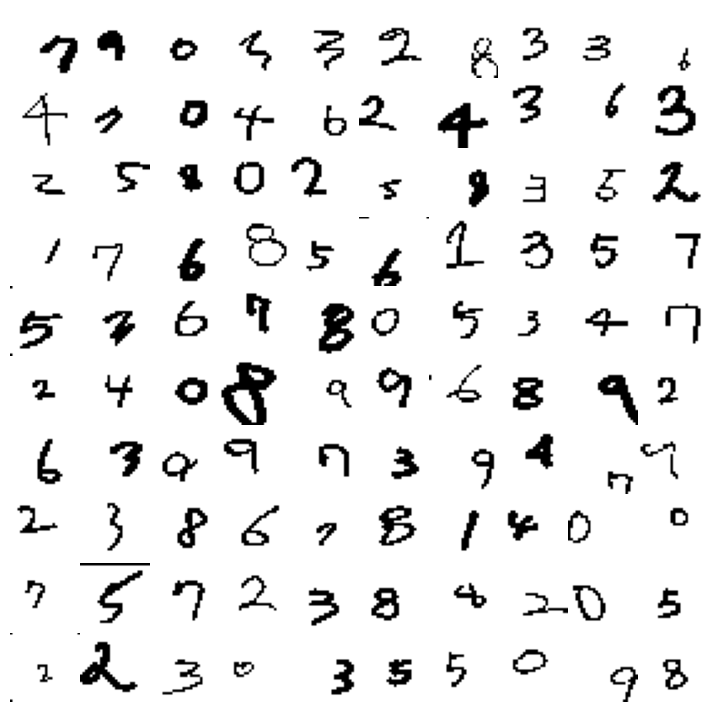

In [9]:
plot_multi(num_trVal_relabeled['img'],0,100)

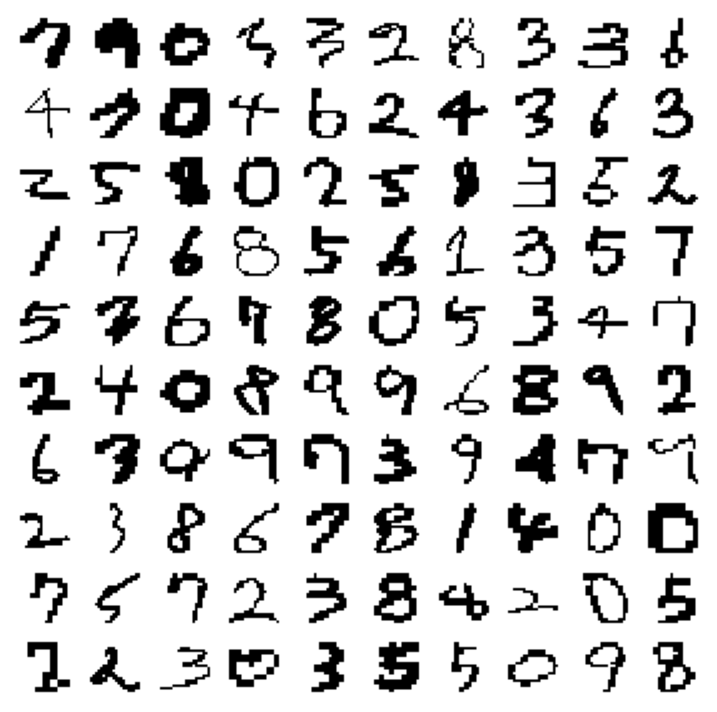

In [10]:
plot_multi(preprocessing(num_trVal_relabeled['img'][:100]),0,100)

## model training - KNN

In [17]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

preprocess = [
    ('binarizer', Binarizer(threshold=0.5)),
    ('preprocess',FunctionTransformer(preprocessing)),
    ("SVM_model", KNeighborsClassifier())
]

param_grid = {
    'n_neighbors': [3, 5, 7],
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'weights': ['uniform', 'distance'],
}

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

knn_grid = make_pipeline(Binarizer(threshold=0.5),
                         FunctionTransformer(preprocessing),
                         GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,cv=3,n_jobs=-1))

In [18]:
knn_grid.fit(X_train_combined_augmented, y_train_combined_augmented)

rebase ongoing
done!
border deletion ongoing
done!
dot deletion ongoing
done!
resize ongoing
done!


C:\Users\Choi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.87409742 0.87963706 0.87559694 0.88082139 0.87282713 0.87818529
        nan 0.87944604        nan 0.88091691        nan 0.87856734
 0.89860554 0.90111748 0.90210124 0.90448902 0.90069723 0.90327603]
  warnings.warn(


Pipeline(steps=[('binarizer', Binarizer(threshold=0.5)),
                ('functiontransformer',
                 FunctionTransformer(func=<function preprocessing at 0x000001D5680BC220>)),
                ('gridsearchcv',
                 GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
                              param_grid={'metric': ['euclidean', 'manhattan',
                                                     'cosine'],
                                          'n_neighbors': [3, 5, 7],
                                          'weights': ['uniform',
                                                      'distance']}))])

In [19]:
knn_grid[2].best_score_

0.9044890162368673

In [20]:
knn_grid[2].best_estimator_

KNeighborsClassifier(metric='cosine', weights='distance')

In [21]:
import pandas as pd

res_csv = pd.DataFrame(knn_grid[2].cv_results_)
res_csv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,7.313883,0.058919,137.908458,1.520077,euclidean,3,uniform,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.872865,0.873639,0.875788,0.874097,0.001236,14
1,7.145806,0.079382,137.232047,0.411721,euclidean,3,distance,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.877851,0.879713,0.881347,0.879637,0.001428,9
2,7.004225,0.315835,138.833991,0.503157,euclidean,5,uniform,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.876361,0.874814,0.875616,0.875597,0.000632,13
3,7.082604,0.189609,137.085251,1.048180,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.880315,0.880258,0.881891,0.880821,0.000757,8
4,0.604934,0.041754,125.036194,1.818889,euclidean,7,uniform,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei...",0.872550,0.871547,0.874384,0.872827,0.001175,15
5,0.605154,0.052315,121.940631,3.674500,euclidean,7,distance,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei...",0.877650,0.877077,0.879828,0.878185,0.001185,12
6,0.636400,0.078249,0.062493,0.025512,manhattan,3,uniform,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",NaN,NaN,NaN,NaN,NaN,16
7,0.593684,0.022096,1143.868232,1.622532,manhattan,3,distance,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.877622,0.879513,0.881203,0.879446,0.001463,10
8,0.600390,0.065177,0.046870,0.012757,manhattan,5,uniform,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",NaN,NaN,NaN,NaN,NaN,16
9,0.656178,0.025513,1143.707713,3.672428,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.880344,0.880258,0.882149,0.880917,0.000872,7


In [18]:
best_model = make_pipeline(Binarizer(threshold=0.5),
                           FunctionTransformer(preprocessing),
                           KNeighborsClassifier(metric='cosine',weights='distance'))
best_model.fit(X_train_combined_augmented, y_train_combined_augmented)

Pipeline(steps=[('binarizer', Binarizer(threshold=0.5)),
                ('functiontransformer',
                 FunctionTransformer(func=<function preprocessing at 0x00000145A94C2660>)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='cosine', weights='distance'))])

In [22]:
knn_grid.score(X_valid_combined_augmented, y_valid_combined_augmented)

rebase ongoing
done!
border deletion ongoing
done!
dot deletion ongoing
done!
resize ongoing
done!


0.9133557457212714

## some error check

### confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix

pred_knn = knn_grid.predict(X_valid_combined_augmented)

cm_knn = confusion_matrix(y_valid_combined_augmented, pred_knn)
cm_knn

rebase ongoing
done!
border deletion ongoing
done!
dot deletion ongoing
done!
resize ongoing
done!


array([[560,  19,   5,   0,  16,   1,   1,  12,   0,   2,   4,   0,   3,
          7,   8],
       [  5, 607,   7,   0,   2,   0,   1,   0,   1,   0,   0,   0,   0,
          9,   7],
       [  6,  13, 528,   0,  45,   1,   1,   0,   1,   1,   0,   3,   0,
          5,   3],
       [  7,   2,   0, 959,   7,   1,   6,   0,   1,   4,   3,   1,   2,
          0,   0],
       [  1,   4,  39,   2, 994,  20,   0,   0,   2,   1,   7,   3,   1,
          0,   1],
       [  0,   1,   2,   7,   6, 951,   9,   1,   0,   1,  10,  13,   0,
          4,   5],
       [  1,   1,   7,   5,   6,  12, 913,   5,   9,   1,  10,  29,  11,
          0,   0],
       [ 35,   5,   0,   1,   2,   4,   3, 840,   5,   7,   4,   1,  45,
          3,   1],
       [  6,   2,   1,   5,   0,   0,  20,   7, 794,  47,   3,  12,   8,
          5,   0],
       [  0,   1,   3,   6,   7,   1,   5,   0,  13, 903,  10,   6,   3,
          0,   0],
       [  0,   2,   2,   8,   3,   2,   1,  10,   2,   3, 959,  11,  36,
       

In [27]:
from sklearn.metrics import multilabel_confusion_matrix

cmm_knn_multiLabel = multilabel_confusion_matrix(y_valid_combined_augmented,pred_knn,labels=knn_grid.classes_)
cmm_knn_multiLabel

array([[[12365,    85],
        [   78,   560]],

       [[12365,    84],
        [   32,   607]],

       [[12378,   103],
        [   79,   528]],

       [[12031,    64],
        [   34,   959]],

       [[11897,   116],
        [   81,   994]],

       [[12017,    61],
        [   59,   951]],

       [[12015,    63],
        [   97,   913]],

       [[12080,    52],
        [  116,   840]],

       [[12124,    54],
        [  116,   794]],

       [[12049,    81],
        [   55,   903]],

       [[11971,    76],
        [   82,   959]],

       [[11989,    85],
        [  121,   893]],

       [[11955,   130],
        [   72,   931]],

       [[12440,    44],
        [   50,   554]],

       [[12422,    36],
        [   62,   568]]], dtype=int64)

In [25]:
knn_grid.classes_

array(['+', '-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '=', 'x'], dtype=object)

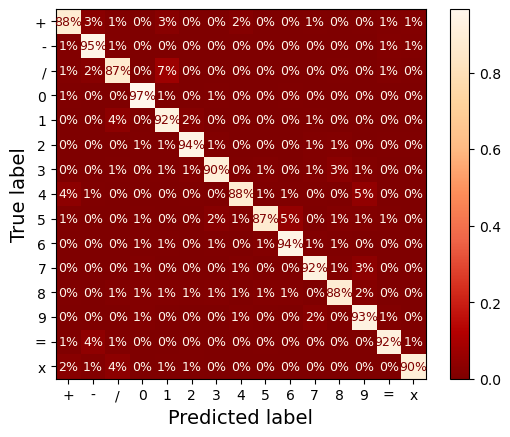

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_valid_combined_augmented, pred_knn,normalize="true",values_format=".0%",cmap="OrRd_r")
plt.show()

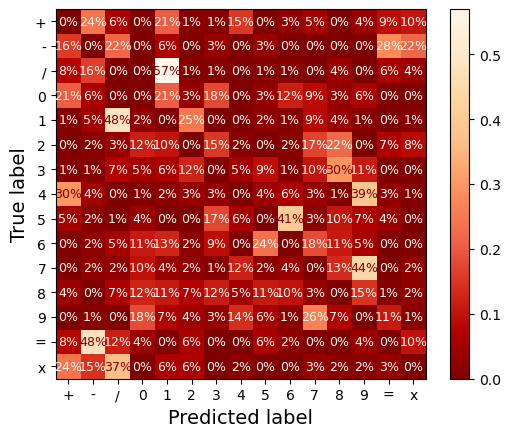

In [30]:
ConfusionMatrixDisplay.from_predictions(y_valid_combined_augmented, pred_knn,sample_weight=(y_valid_combined_augmented != pred_knn),normalize="true",values_format=".0%",cmap="OrRd_r")
plt.show()

In [31]:
cl_div, cl_one = '/', '1'
X_aa = X_valid_combined_augmented[(y_valid_combined_augmented == cl_div) & (pred_knn == cl_div)]
X_ab = X_valid_combined_augmented[(y_valid_combined_augmented == cl_div) & (pred_knn == cl_one)]
X_ba = X_valid_combined_augmented[(y_valid_combined_augmented == cl_one) & (pred_knn == cl_div)]
X_bb = X_valid_combined_augmented[(y_valid_combined_augmented == cl_one) & (pred_knn == cl_one)]

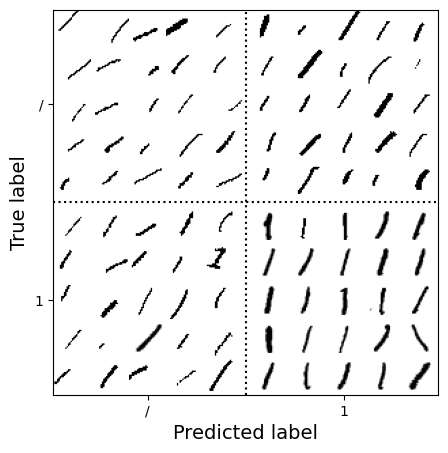

In [35]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_div), str(cl_one)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_one), str(cl_div)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

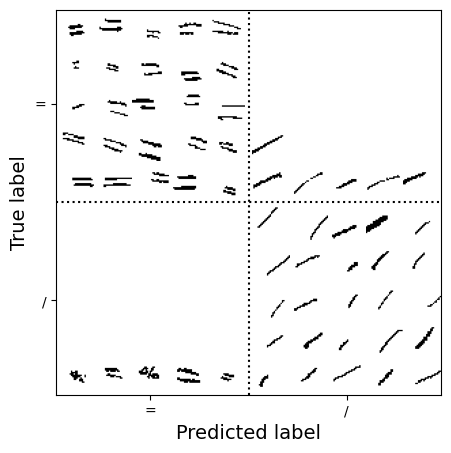

In [36]:
cl_div, cl_one = '=', '/'
X_aa = X_valid_combined_augmented[(y_valid_combined_augmented == cl_div) & (pred_knn == cl_div)]
X_ab = X_valid_combined_augmented[(y_valid_combined_augmented == cl_div) & (pred_knn == cl_one)]
X_ba = X_valid_combined_augmented[(y_valid_combined_augmented == cl_one) & (pred_knn == cl_div)]
X_bb = X_valid_combined_augmented[(y_valid_combined_augmented == cl_one) & (pred_knn == cl_one)]

size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_div), str(cl_one)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_one), str(cl_div)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

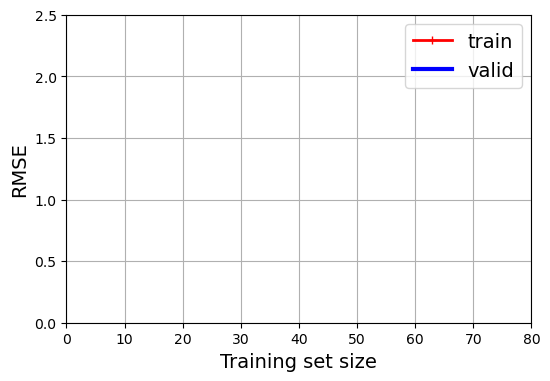

In [44]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    best_model, X_train_combined_augmented, y_train_combined_augmented,n_jobs=-1
    )
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
# save_fig("underfitting_learning_curves_plot")

plt.show()

what? let's try again

Text(0.5, 1.0, 'Learning Curve for KNN')

<Figure size 600x400 with 0 Axes>

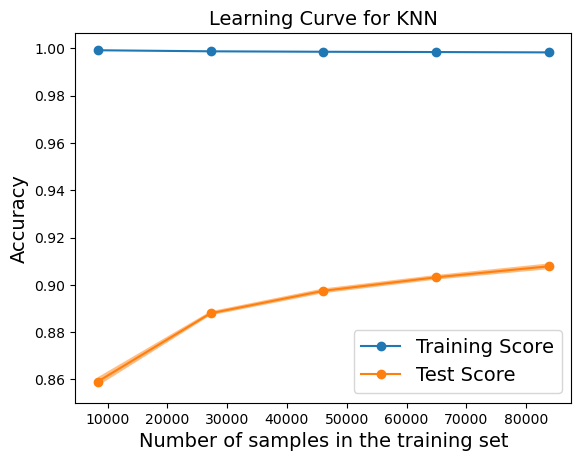

In [19]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

plt.figure(figsize=(6, 4))

common_params = {
    "X": X_train_combined_augmented,
    "y": y_train_combined_augmented,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "score_type": "both",
    "n_jobs": 2,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(best_model, **common_params)
plt.legend(["Training Score", "Test Score"])
plt.title("Learning Curve for KNN")

kinda weird graph, but shall do